In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate

In [2]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [3]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [4]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Shuffle data

In [8]:
from random import shuffle
from scipy import sparse
import anndata as ad

def shuffle_adata(adata):
    
    mapIndexPosition = list(zip(list(adata.obs_names), range(len(adata.obs_names))))
    shuffle(mapIndexPosition)
    obs_names, idx = zip(*mapIndexPosition)
    
    if sparse.issparse(adata.X):        
        x = adata.X.A[idx, :]
    else:
        x = adata.X[idx, :]
        
    adata.obs_names = adata.obs_names.astype(str).str.strip()
    adata.obs.loc[list(obs_names), :]
    
    return ad.AnnData(x, obs=adata.obs.loc[list(obs_names), :])

In [9]:
scrna = shuffle_adata(scrna)
scatac = shuffle_adata(scatac)

# Configure and train the model

In [10]:
model = multigrate.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[None], [None]],
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-6,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [11]:
model.train(
    n_iters=50000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=20000,
    validate_every=5000,
    verbose=1
)

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


 |████████████████████| 100.0% iter=50000/50000, time=269.22(s), loss=0.2011, recon=0.2005, kl=152.7292, integ=0.0502, cycle=0.2062, val_loss=0.1991, val_recon=0.1982, val_kl=147.4581, val_integ=0.0677, val_cycle=0.2032

## Plot training history

In [12]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,5000,0.211132,0.210156,118.032480,0.095472,0.218586,0.202973,0.201884,168.607803,0.104710,0.204232
1,10000,0.202760,0.202057,193.187027,0.062544,0.206262,0.201360,0.200425,208.478378,0.083069,0.203587
2,15000,0.206673,0.205945,205.161136,0.059404,0.210737,0.200615,0.199715,200.898254,0.074935,0.203584
3,20000,0.202855,0.202085,192.069244,0.059745,0.206640,0.200172,0.199250,183.161850,0.073847,0.203796
4,25000,0.204612,0.203885,176.871057,0.055017,0.207988,0.199906,0.198999,173.760452,0.073330,0.203672
5,30000,0.204773,0.204036,178.532211,0.055851,0.208451,0.199602,0.198715,170.287476,0.071686,0.203322
6,35000,0.198945,0.198230,166.754221,0.054825,0.203262,0.199554,0.198676,162.284882,0.071622,0.203934
7,40000,0.201453,0.200760,162.676471,0.052975,0.206082,0.199779,0.198922,156.945862,0.070027,0.205540
8,45000,0.203267,0.202595,156.638770,0.051500,0.207809,0.199264,0.198413,152.268738,0.069846,0.203878
9,49999,0.201130,0.200475,152.729190,0.050194,0.206184,0.199050,0.198226,147.458099,0.067669,0.203153


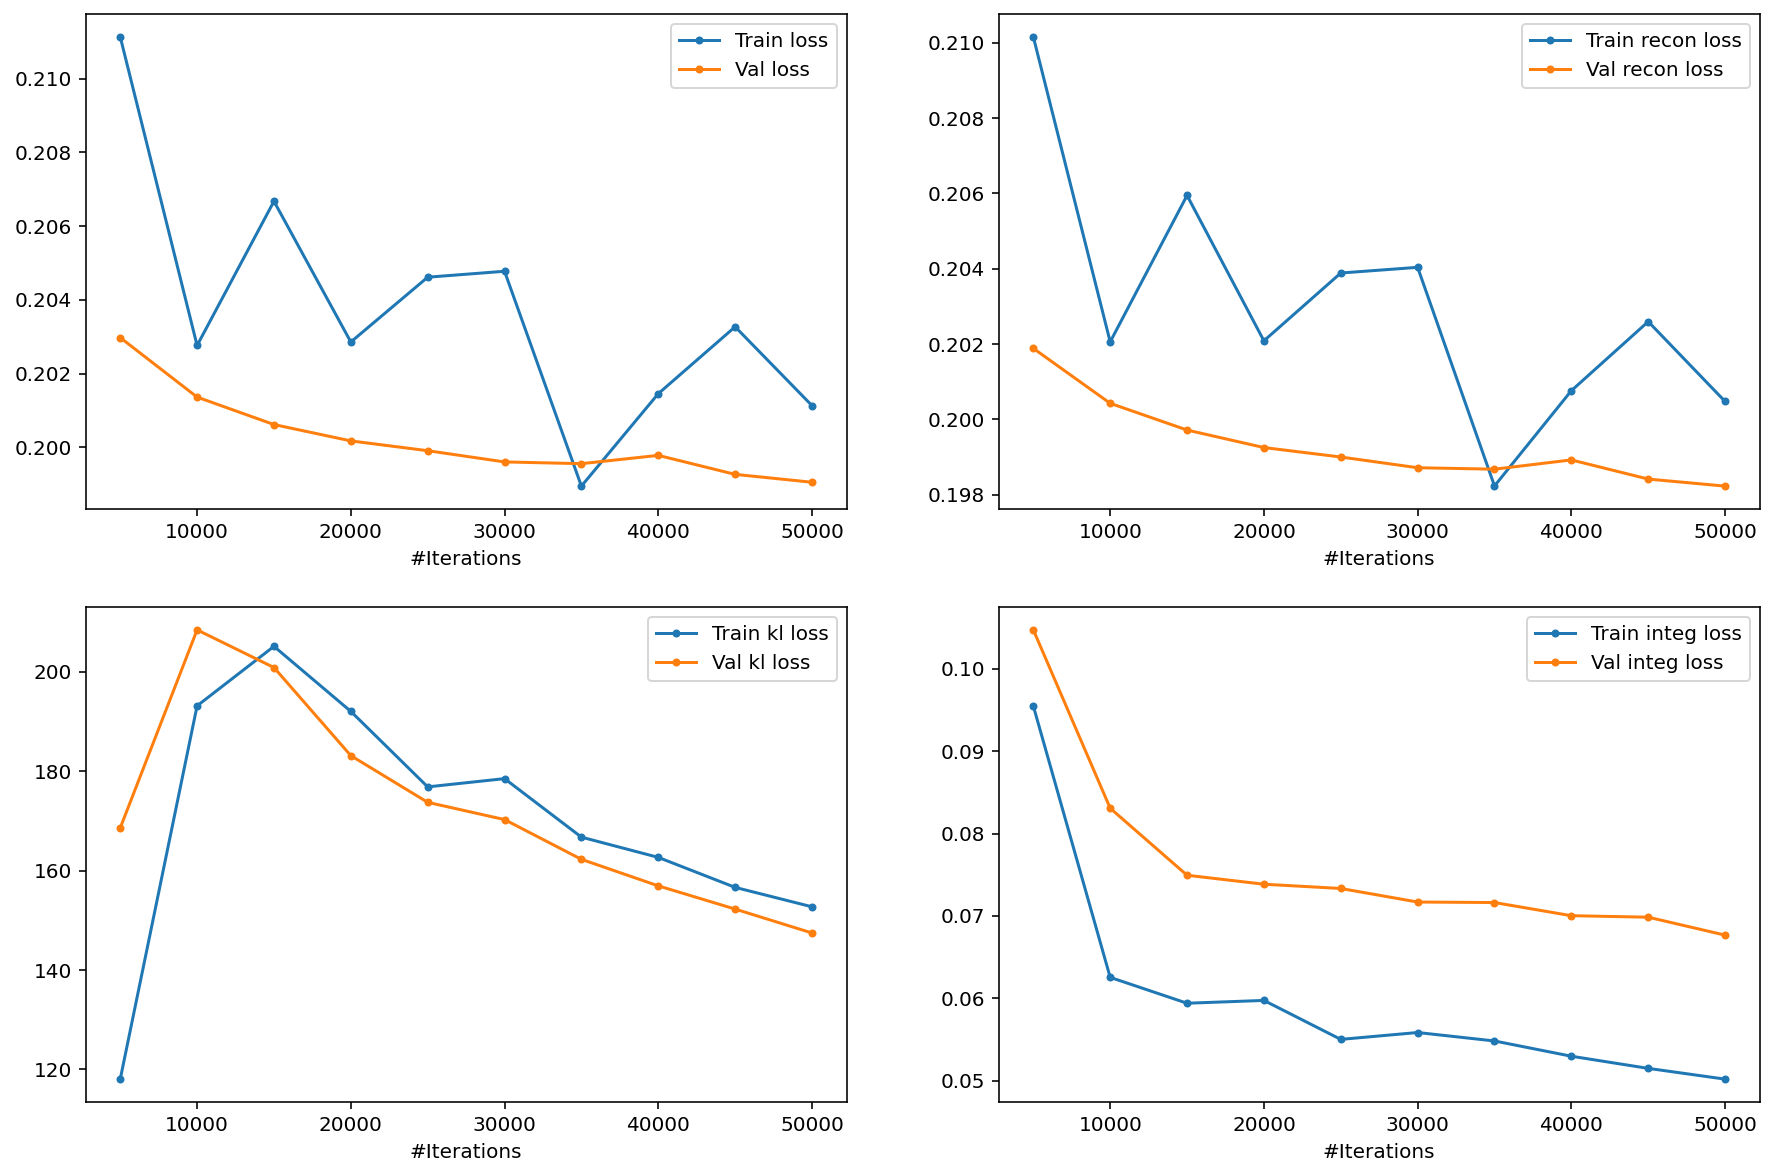

In [13]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

In [14]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 20000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [15]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


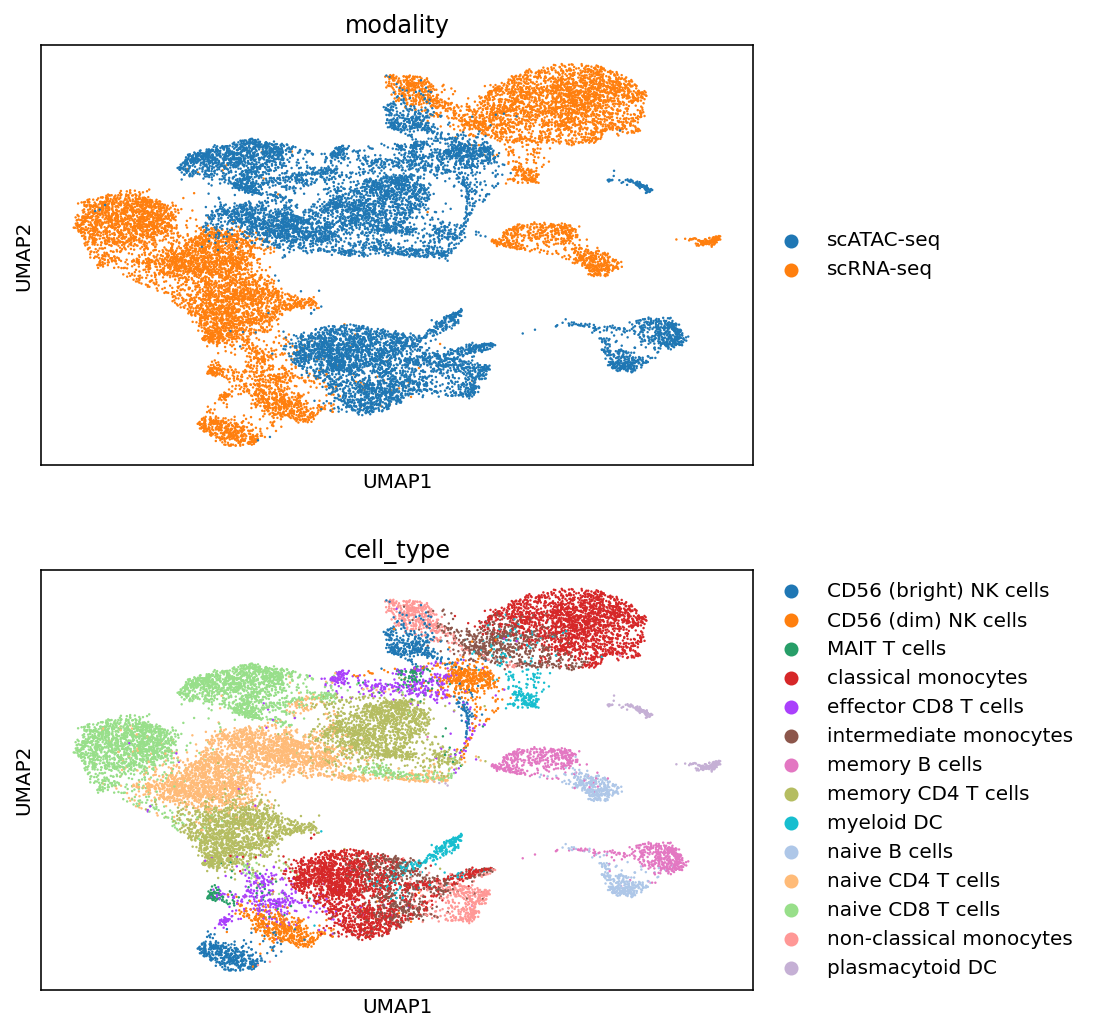

In [16]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

In [26]:
sc.pp.pca(z)
metrics = multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    method='Multigrate'
)
metrics

clustering...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/sit

NMI...
ARI...
silhouette score...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi

,0
NMI_cluster/label,0.670802
ARI_cluster/label,0.503553
ASW_label,0.553201
ASW_label/batch,0.917820
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN
